# NTDS'18 milestone 1: network collection and properties
[Effrosyni Simou](https://lts4.epfl.ch/simou), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: `Team 16`
* Students: `Yinan Zhang, Yu Ting Huang, Shengzhao Xia, Zhantao Deng`
* Dataset: `IMDb Films`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to three sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective 

The purpose of this milestone is to start getting acquainted to the network that you will use for this class. In the first part of the milestone you will import your data using [Pandas](http://pandas.pydata.org) and you will create the adjacency matrix using [Numpy](http://www.numpy.org). This part is project specific. In the second part you will have to compute some basic properties of your network. **For the computation of the properties you are only allowed to use the packages that have been imported in the cell below.** You are not allowed to use any graph-specific toolboxes for this milestone (such as networkx and PyGSP). Furthermore, the aim is not to blindly compute the network properties, but to also start to think about what kind of network you will be working with this semester. 

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
%matplotlib inline

## Part 1 - Import your data and manipulate them. 

###  A. Load your data in a Panda dataframe.

First, you should define and understand what are your nodes, what **features** you have and what are your labels. Please provide below a **Panda dataframe** where each row corresponds to a node with its features and labels. For example, in the the case of the Free Music Archive (FMA) Project, each row of the dataframe would be of the following form:


| Track   |  Feature 1  | Feature 2 | . . . | Feature 518|  Label 1 |  Label 2 |. . .|Label 16|
|:-------:|:-----------:|:---------:|:-----:|:----------:|:--------:|:--------:|:---:|:------:|
|         |             |           |       |            |          |          |     |        |

It is possible that in some of the projects either the features or the labels are not available. This is OK, in that case just make sure that you create a dataframe where each of the rows corresponds to a node and its associated features or labels.

##### 1. load dataset
The author of the dataset provides users two functions to load data, so we directly use them: 'load_tmdb_movies' and 'load_tmdb_credits'.

In [2]:
# set file path
File_path = r'.'
credits_name = r'/tmdb_5000_credits.csv'
movies_name = r'/tmdb_5000_movies.csv'

# use kernal provided by kaggle to load all data
movies_pd = pd.read_csv(File_path + movies_name)
credits_pd = pd.read_csv(File_path + credits_name)

In [3]:
# show dataframe
credits_pd.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [4]:
movies_pd.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [12]:
popularity = movies_pd[['popularity']].sample(frac=0.25).values

In [14]:
np.save('popularity.npy', popularity)

##### 2. extract data
Firstly, we merge movie data with credits data and drop columns which are not considered to be neccessary for graph construction. Result is shown below.

In [5]:
# merge two data sets and extract target features(columns)
movies_credits_pd = movies_pd.merge(credits_pd, left_on = 'id', right_on='movie_id')
movies_credits_extracted_pd = movies_credits_pd[['genres']].copy()
# data clean: drop all rows contain nan
movies_credits_extracted_pd.genres = movies_credits_extracted_pd.genres.apply(lambda x: x if len(x) > 0 else np.nan )
movies_credits_extracted_pd.dropna(inplace=True)
movies_credits_extracted_pd.head(5)

,genres
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""..."
2,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
3,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam..."
4,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."


In [6]:
# data downsampling to reduce processing time
print('The size of original data is', movies_credits_extracted_pd.shape[0], '\n')
movies_credits_extracted_pd = movies_credits_extracted_pd.sample(frac=0.25)
print('After downsampling, the size of date is',movies_credits_extracted_pd.shape[0], '\n')
# reset index of sampled dataframe
movies_credits_extracted_pd.reset_index(inplace=True, drop=True)
movies_credits_extracted_pd.head(3)

The size of original data is 4803 

After downsampling, the size of date is 1201 



,genres
0,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name..."
1,"[{""id"": 28, ""name"": ""Action""}, {""id"": 18, ""nam..."
2,"[{""id"": 18, ""name"": ""Drama""}]"


### B. Create the adjacency matrix of your network.

Remember that there are edges connecting the attributed nodes that you organized in the dataframe above. The connectivity of the network is captured by the adjacency matrix $W$. If $N$ is the number of nodes, the adjacency matrix is an $N \times N$ matrix where the value of $W(i,j)$ is the weight of the edge connecting node $i$ to node $j$.  

There are two possible scenarios for your adjacency matrix construction, as you already learned in the tutorial by Benjamin:

1) The edges are given to you explicitly. In this case you should simply load the file containing the edge information and parse it in order to create your adjacency matrix. See how to do that in [this tutorial](../tutorials/02a_graph_from_edge_list.ipynb).

2) The edges are not given to you. In that case you will have to create a **feature graph**. In order to do that you will have to chose a distance that will quantify how similar two nodes are based on the values in their corresponding feature vectors. [This tutorial](../tutorials/02b_graph_from_features.ipynb) shows you how to build feature graphs when using Euclidean distances between feature vectors. Be curious and **explore other distances** as well! For instance, in the case of high-dimensional feature vectors, you might want to consider using the cosine distance. Once you compute the distances between your nodes you will have a fully connected network. Do not forget to **sparsify** by keeping the most important edges in your network.

Follow the appropriate steps for the construction of the adjacency matrix of your network and provide it in the Numpy array ``adjacency`` below: 

##### 1. data rephrase

We only use movie **genres** as our feature to compute adjecent matrix

In [7]:
# define genres that are considered as features
movies_credits_extracted_pd.genres = movies_credits_extracted_pd.genres.apply(json.loads) # use json to turn string to dict
interest_genre = ["Action","Adventure","Animation", "Biography","Comedy","Crime","Documentary","Drama",
            "Family","Fantasy","Film-Noir","History","Horror","Musical","Mystery","News","Romance",
            "Sci-Fi","Short","Sport","Thriller","War","Western"]
genre_vec_len = len(interest_genre)

# generate feature vectors from 'genres' in the dataframe
# set 1 in corresponding position if the movie has the features 
def extr_genre(kaggle_genre, genre_vec_len):
    genre_vec = np.zeros(genre_vec_len)
    for ct_i in kaggle_genre:
        genre = ct_i['name']
        indices = [i for i, s in enumerate(interest_genre) if genre in s] # generate 0/1
        genre_vec[indices] = 1
    return genre_vec

# show feature vector
movies_credits_featurized_Sris = movies_credits_extracted_pd.genres.apply(lambda x : extr_genre(x, genre_vec_len))
aim_genre = np.array(movies_credits_featurized_Sris[0]).reshape([1,-1])
for i in range(1, movies_credits_featurized_Sris.shape[0]):
    aim_genre = np.concatenate([aim_genre, np.array(movies_credits_featurized_Sris[i]).reshape([1,-1])], axis=0)
features = pd.DataFrame(aim_genre) # turn it into dataframe
features.columns = interest_genre
features.head(2)

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#####  2. generate the distance matrix

1. Euclidean distances:
$$d(u,v) = \|u - v\|_p,$$

In [8]:
def cal_euclidean_dist(features):
    dist_euclidean = np.empty([features.shape[0],features.shape[0]])
    for i in range(features.shape[0]):
        for j in range(features.shape[0]):
            dist_euclidean[i, j] = np.linalg.norm(features.iloc[i].values - features.iloc[j].values, ord=2)
    return dist_euclidean

cal_euclidean_dist(features[:5])

array([[0.        , 1.73205081, 1.        , 1.41421356, 1.        ],
       [1.73205081, 0.        , 1.41421356, 1.73205081, 1.41421356],
       [1.        , 1.41421356, 0.        , 1.        , 0.        ],
       [1.41421356, 1.73205081, 1.        , 0.        , 1.        ],
       [1.        , 1.41421356, 0.        , 1.        , 0.        ]])

2. Other distance
We observe that the cosine similarity between vector '1 0 1 1' and '1 0 1 1' is the same as the similarity between '1 0 0 0' and '1 0 0 0', while the former one should have higher similarity since they have more '1' in common. So, we believe cosine similarity is not an appropriate method to compute distance for our graph. Therefore, we modified cosine distance as below:
$$distance(u,v) = 1 - \frac{u \cdot v} {k},$$
where k is the maximum norm among all feature vectors.

In [9]:
# compute distance matrix
genre_feature_array = np.array(movies_credits_featurized_Sris.tolist())
dot_mat = genre_feature_array @genre_feature_array.T

norm_dist = (genre_feature_array.T * genre_feature_array.T).sum(0, keepdims=True) ** .5
genre_dist_mat = 1 - dot_mat / (norm_dist.max())

In [10]:
genre_dist_mat[:5, :5]

array([[ 0.24407105,  0.62203553,  0.62203553,  0.62203553,  0.62203553],
       [ 0.62203553, -0.13389342,  0.62203553,  0.62203553,  0.62203553],
       [ 0.62203553,  0.62203553,  0.62203553,  0.62203553,  0.62203553],
       [ 0.62203553,  0.62203553,  0.62203553,  0.24407105,  0.62203553],
       [ 0.62203553,  0.62203553,  0.62203553,  0.62203553,  0.62203553]])

##### 3. compute weights

In [11]:
# use the Gaussian function
kernel_width = genre_dist_mat.mean()
weights = np.exp(-genre_dist_mat**2 / kernel_width**2)
weights[:5,:5]

array([[0.90179938, 0.51100655, 0.51100655, 0.51100655, 0.51100655],
       [0.51100655, 0.96937228, 0.51100655, 0.51100655, 0.51100655],
       [0.51100655, 0.51100655, 0.51100655, 0.51100655, 0.51100655],
       [0.51100655, 0.51100655, 0.51100655, 0.90179938, 0.51100655],
       [0.51100655, 0.51100655, 0.51100655, 0.51100655, 0.51100655]])

In [12]:
# zero out diagonal entries
adjacency = weights
tmp1 = np.diag(adjacency)        
tmp2 = np.diag(tmp1)             
adjacency = adjacency - tmp2    
adjacency[:5,:5]

array([[0.        , 0.51100655, 0.51100655, 0.51100655, 0.51100655],
       [0.51100655, 0.        , 0.51100655, 0.51100655, 0.51100655],
       [0.51100655, 0.51100655, 0.        , 0.51100655, 0.51100655],
       [0.51100655, 0.51100655, 0.51100655, 0.        , 0.51100655],
       [0.51100655, 0.51100655, 0.51100655, 0.51100655, 0.        ]])

## Part 2

Execute the cell below to plot the (weighted) adjacency matrix of your network.

Text(0.5,1.05,'adjacency matrix')

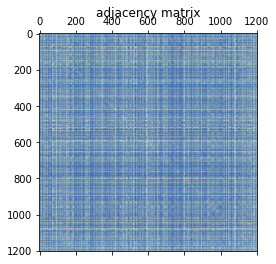

In [13]:
Threshold = 0.5 # take a threshold to make the plot clear and intuitive
plt.spy(adjacency, precision = Threshold, markersize=0.005)
plt.title('adjacency matrix')

### Question 1

What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your network)? How many links $L$ are there in your collected network? Comment on the sparsity of your network.

In [14]:
# calculate Lmax
N = adjacency.shape[0]
full_connect = int(N*(N-1)/2)
print('1. The number of nodes in our network is', N, 'and the maximum number of links in our network is ', full_connect, 'links.')
# calculate L: only sum the edges with a weight larger than threshold
Threshold = 0.5
print('2. When threshold is',Threshold, 'there are', sum(sum(adjacency > Threshold))/2, 'edges in our network.')
print('3. Sparsity of our network is {:.2f}.'.format(sum(sum(adjacency > Threshold))/2/full_connect))

1. The number of nodes in our network is 1201 and the maximum number of links in our network is  720600 links.
2. When threshold is 0.5 there are 365250.0 edges in our network.
3. Sparsity of our network is 0.51.


**Answer:**
1. The number of nodes in our graph is 1201 and the maximum number of links in our graph is  720600 links.
2. Our graph is a weighted graph, so the number of edges and sparsity depend on the threshold which decides whether two nodes are connected.

### Question 2

Is your graph directed or undirected? If it is directed, convert it to an undirected graph by symmetrizing the adjacency matrix.

**Answer: **
1. Our graph is undirected graph.

### Question 3

In the cell below save the features dataframe and the **symmetrized** adjacency matrix. You can use the Pandas ``to_csv`` to save the ``features`` and Numpy's ``save`` to save the ``adjacency``. We will reuse those in the following milestones.

In [15]:
movies_credits_extracted_pd.genres.to_csv('genre.csv')
np.save('adjacency',adjacency)

### Question 4

Are the edges of your graph weighted?

**Answer: **
1. Yes. our graph is weighted.

### Question 5

What is the degree distibution of your network? 

In [16]:
Threshold = 0.5 # set threshold
n_nodes = len(adjacency)
degree = np.sum(adjacency > Threshold, axis = 1)
# show degree distibution
print('The degree distibution of our network describled by a form:')
degree_distribution = pd.DataFrame(degree).T
degree_distribution.index = ['degree']
degree_distribution

The degree distibution of our network describled by a form:


,0,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200
degree,882,852,609,614,609,762,700,558,125,467,...,895,614,530,641,398,152,677,605,835,706


From the figure above, we observe that the number of nodes with low degree is about 4 times greater than the number of nodes with over 1000 degree. This is similar to the degree distribution of random network. Therefore, we draw a log-log figure below.

The degree distibution of our network describled by a histogram:


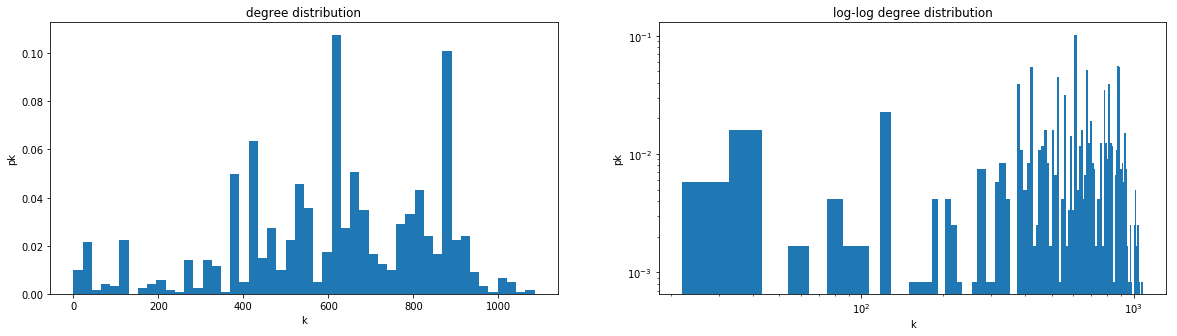

In [17]:
# the degree distibution of our network describled by a histogram:
weights = np.ones_like(degree) / float(n_nodes)
# show degree distibution
print('The degree distibution of our network describled by a histogram:')
plt.figure(figsize =(20,5))
plt.subplot(121)
plt.hist(degree, weights=weights, bins=50)
plt.title("degree distribution")
plt.xlabel("k")
plt.ylabel("pk")

# plot log-log figure to see the degree distibution:
plt.subplot(122)
plt.hist(degree[degree>0], weights=weights[degree>0], bins = 100);
plt.title("log-log degree distribution")
plt.xlabel("k")
plt.ylabel("pk")
plt.xscale('log')
plt.yscale('log')
plt.show()

What is the average degree?

In [18]:
print('When we set threshold to', Threshold, 'the average degree is:{:.2f}'.format(np.mean(degree)))

When we set threshold to 0.5 the average degree is:608.24


### Question 6

Comment on the degree distribution of your network.

**Answer: **
1. The degrees of most nodes are accumulated between 400 and 900.
2. 15% of nodes in our network have a degree around 600 and 10% of nodes have a degree around 900. 
3. Only a few of nodes whose degree are over 1000 and less than 100. 
4. The degree distribution of our network is similar to a Gaussian distribution.

### Question 7

Write a function that takes as input the adjacency matrix of a graph and determines whether the graph is connected or not.

In [19]:
def connected_graph(adjacency):
    """Determines whether a graph is connected.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    bool
        True if the graph is connected, False otherwise.
    """
    bfs_group = []                             # store the connected components of a graph
    picked_mark = np.ones(adjacency.shape[0])  # a mark to indicate the picked nodes
    while (picked_mark == 1).any():            # any point not picked
        node = np.random.choice(np.arange(adjacency.shape[0])[picked_mark == 1], 1) # randomly choose one unpicked point
        bfs_queue, picked_mark = bfs_algrithom(adjacency, picked_mark, node)        # bfs_queue at least has one point
        bfs_group.append(bfs_queue)
    if len(bfs_group) == 1:
        connected_flag = True
        return connected_flag, bfs_group 
    else:
        connected_flag = False
        return connected_flag, bfs_group
    
def bfs_algrithom(adjacency, picked_mark, node = 0):
    node_list = np.arange(adjacency.shape[0])  
    bfs_queue = [np.array(node)]               # a queue with source node already in side
    picked_mark[node] = 0                      # node is picked

    for bfs_queue_component in bfs_queue:
        bfs_queue_buffer = np.array([], dtype = 'int64') # Empty matrix
        for node_index in bfs_queue_component:           # Try to find all nodes linked with members in bfs_queue_component
            bool_vector = (adjacency[node_index] != 0)
            temp = node_list[bool_vector]                     # Pick the nodes linked with node_index
            pick_now = temp[picked_mark[bool_vector] == 1]    # Delete nodes that already picked
            if pick_now.shape[0] != 0:                        # Cheak whether there are new points
                picked_mark[pick_now] = 0
                bfs_queue_buffer = np.concatenate([bfs_queue_buffer,pick_now], axis = 0)
        if bfs_queue_buffer.shape[0] != 0:
            bfs_queue.append(bfs_queue_buffer)
        else:
            break
    return bfs_queue, picked_mark

Is your graph connected? Run the ``connected_graph`` function to determine your answer.

In [20]:
Threshold = 0.5 # set threshold
adjacency_thres = adjacency.copy()
adjacency_thres[adjacency_thres < Threshold] = 0

In [21]:
connected_flag, bfs_group = connected_graph(adjacency_thres)
print('When we set threshold to', Threshold, ', the statement that our graph is connected is', connected_flag)

When we set threshold to 0.5 , the statement that our graph is connected is False


**Answer:**
1. After downsampling, When we set threshold to 0.5, our network is not connected.
2. The result depende on how the downsampling is conducted and the threshold we set.

### Question 8

Write a function that extracts the connected components of a graph.

In [22]:
def find_components(adjacency):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    _, bfs_group = connected_graph(adjacency)        # get the connected components of a graph
    component_size = []                              # store the size of each component
    adjacency_list = []
    for bfs_queue in bfs_group:
        temp = adjacency.copy()
        node_picked = np.array([],dtype='int64')
        picked_mark = np.zeros(adjacency.shape[0])   # a mark to indicate whether the node is picked or not
        for bfs_queue_component in bfs_queue:
            node_picked = np.concatenate([node_picked, bfs_queue_component])
        for i in node_picked:
            picked_mark[i] = 1
        temp[picked_mark == 0,:] = 0
        temp[:,picked_mark == 0] = 0
        adjacency_list.append(temp)
        component_size.append(len(node_picked))
    return adjacency_list, component_size

How many connected components is your network composed of? What is the size of the largest connected component? Run the ``find_components`` function to determine your answer. 

In [23]:
adjacency_list, component_size = find_components(adjacency_thres)
component_num = len(adjacency_list)
print('When we set threshold to',Threshold, ', the number of connected components in our graph is', component_num, 
      'and their size is/are',component_size,'.')
print('The size of the largest connected component is {}.'.format(max(component_size)))

When we set threshold to 0.5 , the number of connected components in our graph is 13 and their size is/are [1189, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] .
The size of the largest connected component is 1189.


# **Answer: **
1. After downsampling, When we set threshold to 0.5 , the number of connected components in our graph is 13 and their size is 1189.
2. The result depende on how the downsampling is conducted and the threshold we set.

### Question 9

Write a function that takes as input the adjacency matrix and a node (`source`) and returns the length of the shortest path between that node and all nodes in the graph using Dijkstra's algorithm. **For the purposes of this assignment we are interested in the hop distance between nodes, not in the sum of weights. **

Hint: You might want to mask the adjacency matrix in the function ``compute_shortest_path_lengths`` in order to make sure you obtain a binary adjacency matrix. 

In [24]:
def compute_shortest_path_lengths(adjacency, source):
    """Compute the shortest path length between a source node and all nodes.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    
    Returns
    -------
    list of ints
        The length of the shortest path from source to all nodes. Returned list should be of length n_nodes.
    """
    # the main structure is the same as question 7, but has a few modifications
    length = adjacency.shape[0]
    shortest_path_lengths = -1 * np.ones(length)    # like the BFS_vec in question 7, here we store the path length rather than connected nodes
                                                    # -1 means not connected
    shortest_path_lengths[source] = 0;  # source node, path length is 0
    
    team = np.array( np.where(adjacency[source,:] > 0)[0] )  # same as question 7, initalizing the queue with nodes connected to the source node
    team_dist = np.ones(len(team))      # storing path lenth of the node in the 'team' . For example:
                                        # team = [2 3 5 4 2], team_dist = [1 1 2 2 3], means path length from source to node 2,3 is 1, to nodes 5,4 is 2, etc.
    
    shortest_path_lengths[team] = 1     # path length of all nodes connnected to the source node is 1 
    
    ct_i = 0
    while np.sum(team) != 0:
        
        if ct_i <= len(team):   
            
            # find newly connected nodes
            new_index = np.setdiff1d( np.where(adjacency[team[ct_i], :] > 0)[0], np.where(shortest_path_lengths > -1)[0] )
            
            if new_index.size != 0:                                              # if we do find new nodes
                # since new nodes connectted to the node in team[ct_i], path length of these new nodes should be path length of team[ct_i] + 1
                # so, here below is team_dist[ct_i] + 1 
                shortest_path_lengths[new_index] = team_dist[ct_i] + 1           
                team = np.append( team, new_index )                              # append these new node to vecter 'team' 
                team_dist = np.append( team_dist, np.ones(len(new_index))*(team_dist[ct_i] + 1) )    # record path length of these new nodes which are added to the 'team'
                
            team[ct_i] = 0
            
            ct_i += 1
    
    return shortest_path_lengths

In [25]:
Threshold = 0.5
adjacency_thres = np.where(adjacency <= Threshold, 0, 1)
distance = compute_shortest_path_lengths(adjacency_thres, 0)

In [26]:
print('When we set threshold to',Threshold, ',the length of the shortest path between source node and all the other nodes is', distance.max())

When we set threshold to 0.5 ,the length of the shortest path between source node and all the other nodes is 2.0


**Answer: **
1. After after downsampling, when we let threshold equal to 0.5, the shortest path of the dominant component is 2.
2. The result depende on how the downsampling is conducted and the threshold we set.

### Question 10

The diameter of the graph is the length of the longest shortest path between any pair of nodes. Use the above developed function to compute the diameter of the graph (or the diameter of the largest connected component of the graph if the graph is not connected). If your graph (or largest connected component) is very large, computing the diameter will take very long. In that case downsample your graph so that it has 1.000 nodes. There are many ways to reduce the size of a graph. For the purposes of this milestone you can chose to randomly select 1.000 nodes. 

In [27]:
# adjacency_thres：Threshold = 0.5
# our down sampled graph has 1201 nodes
components, component_size = find_components(adjacency_thres)
largest_component = components[component_size.index(max(component_size))]

diameter = 0
counter = 0
# search the longest shortest path for all nodes, this is really time comsuming
for node_i in range(largest_component.shape[0]):
    all_path_lengths = compute_shortest_path_lengths(largest_component,node_i)
    diameter = diameter if diameter >= all_path_lengths.max() else all_path_lengths.max()

In [28]:
print('When we set threshold to',Threshold, ', the diameter of our graph is:',all_path_lengths.max())

When we set threshold to 0.5 , the diameter of our graph is: 2.0


**Answer: **
1. When we set threshold to 0.5, the diameter of our graph is 2.

### Question 11

Write a function that takes as input the adjacency matrix, a path length, and two nodes (`source` and `target`), and returns the number of paths of the given length between them.

In [29]:
def compute_paths(adjacency, source, target, length):
    """Compute the number of paths of a given length between a source and target node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    target: int
        The target node. A number between 0 and n_nodes-1.
    length: int
        The path length to be considered.
    
    Returns
    -------
    int
        The number of paths.
    """
    
    adj = adjacency.copy()
    
    Matrix = np.identity(adj.shape[0])
    
    for i in range (length):
        
        Matrix = Matrix.dot(adj)
        
    n_paths = Matrix[source][target]
    
    return n_paths

Test your function on 5 pairs of nodes, with different lengths.

In [30]:
Threshold = 0.5
adjacency_thres = np.where(adjacency <= Threshold, 0, 1)

print('When we set threshold to',Threshold, ',the number of paths of the given length between the 5 pairs of nodes is:')
print(compute_paths(adjacency_thres, 0, 10, 1))
print(compute_paths(adjacency_thres, 0, 10, 2))
print(compute_paths(adjacency_thres, 0, 10, 3))
print(compute_paths(adjacency_thres, 23, 67, 2))
print(compute_paths(adjacency_thres, 15, 93, 4))

When we set threshold to 0.5 ,the number of paths of the given length between the 5 pairs of nodes is:
1.0
423.0
267792.0
392.0
114133391.0


### Question 12

How many paths of length 3 are there in your graph? Hint: calling the `compute_paths` function on every pair of node is not an efficient way to do it.

In [31]:
def compute_paths_of_specific_path(adjacency, length):
    adj = adjacency.copy()

    Matrix = np.identity(adj.shape[0])
    
    for i in range (length - 1):
        
        Matrix = Matrix.dot(adj)
        
    return Matrix.sum()

In [32]:
Threshold = 0.5

adjacency_thres = np.where(adjacency <= Threshold, 0, 1)

print('When we set threshold to',Threshold, ', there are',compute_paths_of_specific_path(adjacency_thres, 3),'paths of length 3 in our graph')

When we set threshold to 0.5 , there are 510112550.0 paths of length 3 in our graph


**Answer: **
1. When we set threshold to 0.5 , there are 510112550 paths of length 3 in our graph.

### Question 13

Write a function that takes as input the adjacency matrix of your graph (or of the largest connected component of your graph) and a node and returns the clustering coefficient of that node. 

In [33]:
# compute the largest connected component of graph
Threshold = 0.5
components, component_size = find_components(adjacency)
largest_component = components[component_size.index(max(component_size))]
unweighted_adjacency = np.where(largest_component <= Threshold, 0, 1) #find the largest component and turn it into an unweighted matrix

print('When we set threshold to',Threshold, ', we have',component_num,'components ''and the size of largest component is',max(component_size))

When we set threshold to 0.5 , we have 13 components and the size of largest component is 1201


In [34]:
def compute_clustering_coefficient(unweighted_adjacency, node):
    """Compute the clustering coefficient of a node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    node: int
        The node whose clustering coefficient will be computed. A number between 0 and n_nodes-1.
    
    Returns
    -------
    float
        The clustering coefficient of the node. A number between 0 and 1.
    """

    k_node_num = np.sum(unweighted_adjacency[node]) #Given a node, find the total number of its neighbors
    k_node = np.where(unweighted_adjacency[node] == 1)[0] #find the indexes of its neighbors
    
    tmp1 = unweighted_adjacency[k_node, :]
    tmp2 = tmp1[:, k_node]#find the adjacency that its neighbors form
    
    L = np.sum(tmp2)/2
    
    if k_node_num == 0 or k_node_num ==1:
        clustering_coefficient = 0#If a node has no neighbors or only one neighbor, then the clustering efficiency is 0 
    else:
        clustering_coefficient = 2*L/(k_node_num*(k_node_num-1))#calculate clustering efficency
    return clustering_coefficient

In [35]:
#you can choose one node to calculcate clustering efficency
node = 8
print('When we set threshold to',Threshold, ', the clustering coefficient of node', node,'is', compute_clustering_coefficient( unweighted_adjacency, node ))

When we set threshold to 0.5 , the clustering coefficient of node 8 is 0.9566451612903226


**Answer: **
1. When we set threshold to 0.5 , the clustering coefficient of node 8 is 0.9566

### Question 14

What is the average clustering coefficient of your graph (or of the largest connected component of your graph if your graph is disconnected)? Use the function ``compute_clustering_coefficient`` to determine your answer.

In [36]:
def compute_average_clustering_coefficient(adjacency):
    ''' Calculate clustering efficency for each node and give the mean value
    '''
    
    clustering_coefficient = []
    
    for i in range(adjacency.shape[0]):
        
        clustering_coefficient.append(compute_clustering_coefficient(unweighted_adjacency, i))
        
    average_clustering_coefficient = np.sum(clustering_coefficient)/adjacency.shape[0]
    
    return average_clustering_coefficient

In [37]:
unweighted_adjacency = np.where(largest_component <= Threshold, 0, 1)
print('When we set threshold to',Threshold, ', the average clustering coefficient of our graph is',compute_average_clustering_coefficient(unweighted_adjacency))

When we set threshold to 0.5 , the average clustering coefficient of our graph is 0.8108498998210212


**Answer: **
1. When we set threshold to 0.5 , the average clustering coefficient of our graph is 0.8108.